# The Returns to Altruistic Risk Taking

If you're trying to improve the world, should you avoid uncertainty or embrace it?  Is it better to spend money on a temporary health intervention or fund research to eventually find a cure?  [In a previous post](https://pstblog.com/2017/12/02/risk-return), I tried to answer these questions by looking at standalone data from a variety of sources. Some of the sources shared similar enough units that they could be combined, so I tried to do so below.  

I take two approaches to determine if there is evidence of a return to risk.  The first is to run a simple linear regression through the data to see if it has a positive slope. This technique isn't ideal though -- imagine if you calculated the cost effectiveness for every possible action including things like "lighting $1000 on fire".  This would result in many useless interventions that would pull down the slope of the linear regression.  

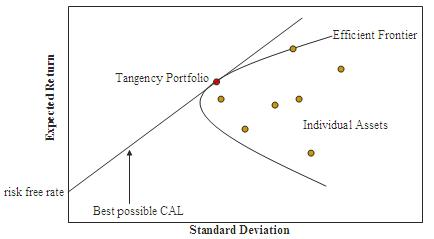

So my second approach is to see if the frontier that encloses the top estimates has a positive slope.  In Modern Portfolio Theory, this frontier is called the [efficient frontier](https://en.wikipedia.org/wiki/Efficient_frontier), which I've written about [before](https://github.com/psthomas/efficient-frontier).  I didn't have enough data to test out this theory in the past, but the combination of all these sources makes it possible to do so now.  

In [3]:
%matplotlib inline

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

import cvxopt as opt
from cvxopt import blas, solvers

matplotlib.style.use('ggplot')

In [2]:
import altair as alt
from vega_datasets import data
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [4]:
#Helper function for viewing df
def ends(df, x=5):
    fill = ['...' for i in range(len(df.columns))]
    fill_df = pd.DataFrame([fill], columns=list(df))
    return df.head(x).append(fill_df).append(df.tail(x))

# Data Imports

The FHI, NICE, GiveWell, and DCP2 data are all pretty straightforward to import. There's more information on the sources of these data in the other notebook, `returns.ipynb`.   

In [5]:
fhi_df = pd.read_csv('./data/fhi_data.csv')
# Convert sigma to stdev, still meaningful for non-normal distributions:
# https://en.wikipedia.org/wiki/Log-normal_distribution
# https://en.wikipedia.org/wiki/Chebyshev's_inequality
# https://stats.stackexchange.com/questions/173715
fhi_df['stdev'] = np.sqrt((np.exp(fhi_df['sigma'])**2 - 1) * fhi_df['mean']**2)

t = fhi_df['mean'].mean()

def downside_risk(series):
    return np.sqrt((np.minimum(0.0, series - t)**2).sum()/series.size)

#Sample from probability distributions to generate downside risk estimates:
columns = fhi_df['disease']
samples = []
n = 10000
for i,r in fhi_df.iterrows():
    samples.append(np.random.lognormal(r['mu'], r['sigma'], n))

data = np.array(samples).transpose()
sample_df = pd.DataFrame(data, columns=columns)
sample_df = sample_df.agg(downside_risk).to_frame(name="downside_risk")
fhi_df = fhi_df.join(sample_df, on='disease')

fhi_df.sort_values(by='mean', ascending=False)

,group,disease,mu,sigma,median,mean,stdev,downside_risk
3,Diarrhoeal disease,Diarrhoeal diseases,-1.466692,4.391203,0.230687,3549.783221,286578.696559,633.028906
14,Meningitis,Meningititis,-2.503745,4.463425,0.081778,1732.527683,150346.122518,641.949568
11,Parasitic and vector diseases,Leishmaniasis,-3.706662,4.721702,0.024559,1703.723172,191421.556624,647.315173
17,Leprosy,Leprosy,-5.014960,4.843504,0.006638,824.521890,104639.483899,651.530687
13,Parasitic and vector diseases,Trypanosomiasis,-5.296044,4.895739,0.005011,802.785665,107344.569326,652.335344
1,Malaria,Malaria,-3.161076,4.437962,0.042380,801.655755,67817.253156,646.442565
16,Meningitis,Multiple salmonella infections,-1.895189,4.127971,0.150290,753.616047,46757.225910,641.341649
15,Meningitis,Typhoid and paratyphoid fever,-2.798470,4.327229,0.060903,709.092672,53697.852674,645.516560
12,Parasitic and vector diseases,Chagas disease,-4.955053,4.740730,0.007048,534.967344,61260.904879,651.958167
0,HIV,HIV,-3.783888,4.358867,0.022734,303.678832,23736.173393,650.645080


In [6]:
ph_df = pd.read_csv('./data/DCP2_data.csv')
ph_df = ph_df.apply(pd.to_numeric, errors='ignore')
ph_df.rename(columns={'Spread(DALY/1000USD)': 'spread', 
                      'cost_effectiveness(DALY/1000USD)': 'cost_effectiveness'}, 
             inplace=True)

ph_df[['condition', 'intervention','cost_effectiveness', 'spread']] \
    .sort_values('cost_effectiveness', ascending=False)

,condition,intervention,cost_effectiveness,spread
29,Malaria,Intermittent preventive treatment in pregnancy...,142.857143,111.111111
28,Malaria,Insecticidetreated bednets,90.909091,83.333333
2,Lymphatic filariasis,Annual mass drug administration,66.666667,43.478261
41,Malaria,Residual household spraying,58.823529,66.666667
30,Malaria,Intermittent preventive treatment in pregnancy...,52.631579,90.909091
27,Traffic accidents,"Increased speeding penalties, enforcement, med...",47.619048,28.571429
16,Lymphatic filariasis,Diethyl carbamazine salt,45.454545,23.809524
39,HIV/AIDS,Peer and education programs for high-risk groups,27.027027,16.129032
52,HIV/AIDS,Voluntary counseling and testing,21.276596,13.333333
9,Tuberculosis (endemic),BCG vaccine,14.705882,37.037037


In [7]:
nice_df = pd.read_csv('./data/nice_data.csv', na_filter = False)

nice_df = nice_df[(nice_df['range'] != 'NA') & 
                  (nice_df['range'] != 'N/A') &
                  (nice_df['median'] != 'N/A')]

nice_df['spread'] = nice_df['range'] \
    .str.split('–') \
    .apply(lambda x: abs(int(x[0]) - int(x[1])))

nice_df = nice_df.apply(pd.to_numeric, errors='ignore')

del nice_df['range']

#Invert so large numbers are better, convert to QALY/1000£
nice_df['spread'] = (1/nice_df['spread'])*1000
nice_df['median'] = (1/nice_df['median'])*1000

nice_df.sort_values(by='median', ascending=False)

,guidance_topic,comparator,median,num_estimates,spread
53,Smoking cessation—general population: client c...,Background quit rate; no intervention or usua...,20.000000,8.0,2.288330
4,Exercise prescriptions,Advice,12.987013,4.0,7.194245
56,Smoking cessation—general population: recruitm...,Background quit rate; no intervention or advice,3.846154,15.0,0.074499
62,Smoking cessation —general population: dentist...,Usual care,3.311258,3.0,10.989011
51,Smoking cessation—general population: incentiv...,Intervention no NRT,2.793296,2.0,1.597444
2,BA (5 min plus self-help),Background quit rate,2.702703,8.0,1.801802
54,Smoking cessation—general population: proactiv...,Usual care or intervention but no telephone c...,2.341920,9.0,0.683527
58,Smoking cessation—general population: identify...,No intervention,1.984127,4.0,0.243902
61,Smoking cessation—general population: pharmaci...,Usual care,1.831502,2.0,4.608295
0,BA only (5 min),Background quit rate,1.366120,8.0,0.909091


In [8]:
gw_df = pd.read_csv('./data/gw_data.csv')

# Mean of the monte carlo intervention means:
t = gw_df.agg('mean').mean()

def downside_risk(series):
    return np.sqrt((np.minimum(0.0, series - t)**2).sum()/series.size)

gw_df = gw_df.agg(['mean', 'std', downside_risk]).T
gw_df.reset_index(inplace=True)

renames = {'iodine': 'iodine supplementation', 'dtw':'Deworm the World', 
           'sci': 'Schistosomiasis Control Initiative', 'ss': 'Sightsavers',
           'lead': 'Household lead pipe replacement', 
           'bednets': 'Against Malaria Foundation',
           'smc': 'Malaria Consortium',
           'cash': 'GiveDirectly'}

gw_df['intervention'] = gw_df['index'].apply(lambda x: renames[x])
del gw_df['index']

gw_df.sort_values(by='mean', ascending=False)

,mean,std,downside_risk,intervention
6,41.418910,41.364215,1.438643,iodine supplementation
0,12.039437,11.307934,3.733827,Deworm the World
1,9.064981,8.657475,4.589170,Schistosomiasis Control Initiative
2,4.894470,4.598517,6.279625,Sightsavers
7,4.519663,14.533890,9.365194,Household lead pipe replacement
4,3.572679,2.964297,6.958995,Against Malaria Foundation
5,3.222606,2.162316,7.082046,Malaria Consortium
3,1.060328,0.380961,8.921943,GiveDirectly


# GHCEA Data

All the other imports are pretty straightforward, but the [Global Health Cost Effectiveness Analysis Registry](http://healtheconomics.tuftsmedicalcenter.org/ghcearegistry/) (GHCEA) data required more wrangling.  First, I needed to convert the confidence intervals to standard deviations, which requires making a bunch of assumptions.  Here's what the Cochrane Review [has to say](http://handbook-5-1.cochrane.org/chapter_7/7_7_3_2_obtaining_standard_deviations_from_standard_errors_and.htm) about this process: 

> Confidence intervals for means can also be used to calculate standard deviations . . . Most confidence intervals are 95% confidence intervals. If the sample size is large (say bigger than 100 in each group), the 95% confidence interval is 3.92 standard errors wide (3.92 = 2 × 1.96). The standard deviation for each group is obtained by dividing the length of the confidence interval by 3.92, and then multiplying by the square root of the sample size:  
> `SD = np.sqrt(N) * (upper_limit - lower_limit)/3.92`  
> For 90% confidence intervals 3.92 should be replaced by 3.29, and for 99% confidence intervals it should be replaced by 5.15.

So if I assume a 95% confidence intervals unless otherwise stated, N=1000 simulations for their monte carlo analyses, and simulations samples that follow a normal distribution, I can back-calculate the standard deviation.  This assumes quite a lot (especially the N=1000 simulations part), so I'd be open to advice on how to better handle this.  In addition to the calculations above, I filter out any GHCEA studies that were rated below 4.5 by reviewers on a 1-7 quality scale.  The end result is 653 interventions with standard deviations and cost effectiveness estimates.  

In [9]:
interval_df = pd.read_csv('./data/GHCEA_manualintervals.csv')

#Remove non-integer rows
interval_df  = interval_df[interval_df['DisplayRatio'].apply(lambda x: str(x).isdigit())]

#Convert to floats
interval_df['DisplayRatio'] = interval_df['DisplayRatio'].astype(float)

#Eliminate non-usable CIs, from manual process
interval_df = interval_df[interval_df['CI_Usable'] == 1]

#Just use USD for now, because conversion ratio at time is unknown for others
# Only 9 AUD, 1 EUR filtered out
interval_df = interval_df[interval_df['CI_Currency'] == 'USD']

#Convert to DALY/1000USD
interval_df['DisplayRatio'] = (1/interval_df['DisplayRatio'])*1000
interval_df['CI_Difference'] = (1/interval_df['CI_Difference'])*1000

#Remove non standard CIs
interval_df = interval_df[(~interval_df['CI_Type'].isin(['INR', 'IQR']))]

#Also remove studies with quality rating lower than 4.5 out of 7:
interval_df = interval_df[interval_df['Rating'] >= 4.5] #4 

def handle_intervals(row):
    if row['CI_Type'] == 'range':
        return row['CI_Difference'] / 2
    elif row['CI_Type'] == '95':
        return (row['CI_Difference'] / 3.96)*np.sqrt(1000)
    elif row['CI_Type'] == '91':
        return (row['CI_Difference'] / 3.29)*np.sqrt(1000)
    elif row['CI_Type'] == '80':
        #Simple interpolation for denominator
        denom = 1.96 + ((3.29 - 1.96)/(90-68))*(80-68)
        return (row['CI_Difference'] / denom)*np.sqrt(1000)
        
interval_df['stdev'] = interval_df.apply(handle_intervals, axis=1)

interval_df[['PubYear','InterventionPhrase', 'DisplayRatio', 'stdev']] \
    .sort_values(by='DisplayRatio', ascending=False)

,PubYear,InterventionPhrase,DisplayRatio,stdev
564,2010,Preventive treatment of malaria in pregnancy w...,1000.000000,2618.212999
846,2011,Routine measles-containing vaccine followed by...,1000.000000,5703.964033
413,2014,Aspirin alone (325 mg initial dose & subsequen...,1000.000000,12879.918785
921,2014,New tuberculosis vaccine (40% efficacy),1000.000000,7394.027451
571,2010,Preventive treatment of malaria in pregnancy w...,1000.000000,104.797239
514,2013,Syphilis screening before third trimester + tr...,500.000000,2402.946550
338,2010,Intermittent preventive treatment in infants (...,333.333333,2001.390889
523,2013,Syphilis screening before third trimester + tr...,333.333333,1373.112314
887,2012,Brief smoking cessation advice + Bupropion,333.333333,0.461113
912,2013,Syphilis screening before third trimester + tr...,333.333333,1597.109929


In [10]:
#interval_df[interval_df['InterventionPhrase'] == "Policy intervention to reduce sodium consumption by 10%"]
#Ok, there are 183 of these. . . I guess if they tested all those interventions, why not include them?

# Putting It All Together

Because both the GiveWell and Future of Humanity Institute (FHI) data share the same units, we can combine them to get a sense of the scale. Also, if we lazily assume that we can estimate the standard deviation of the Disease Control Priorities (DCP2) and National Institute for Health and Care Excellence (NICE) estimates by dividing the [range of the estimates by two](https://stats.stackexchange.com/questions/69575/relationship-between-the-range-and-the-standard-deviation), we can include those as well.  Note also that the NICE estimates are median results while Givewell and FHI are mean results, so this might need to be changed.

One final thing to consider: the Givewell estimates are from shovel-ready charities accepting donations, while many of the others measure impact against a counterfactual using an [Incremental Cost Effectiveness Ratio](https://en.wikipedia.org/wiki/Incremental_cost-effectiveness_ratio) without a clear avenue for donors to make that change happen.  Instead, many of these interventions probably need to be implemented at the hospital, insurer, or federal policy level rather than through a charity. 

After the above wrangling, the GHCEA estimates have units that match the rest as well: standard deviations and mean impacts.  Below, I concatenate all the different sources and look at some histograms to get an idea of the distributions (mostly lognormal).  Next, I fit some curves, run the portfolio optimization, and visualize the results. 

In [11]:
temp1_df = fhi_df[['disease','mean', 'stdev']].copy()
temp1_df.rename(columns={'mean': 'cost_effectiveness', 'disease': 'intervention'}, inplace=True)
temp1_df['intervention'] = 'Research - ' + temp1_df['intervention']
temp1_df['source'] = 'FHI'

temp2_df = gw_df[['intervention', 'mean', 'std']].copy() #.reset_index().copy()
#'index': 'intervention',
temp2_df.rename(columns={'mean': 'cost_effectiveness', 'std':'stdev'}, inplace=True)
temp2_df['source'] = 'GW'

# Is this the cost effectiveness here a mean or median?
temp3_df = ph_df[['intervention', 'cost_effectiveness', 'spread']].copy()
temp3_df['stdev'] = temp3_df['spread'] / 2
del temp3_df['spread']
temp3_df['source'] = 'DCP2'

# The cost effectiveness here is a median, others above are means. . . 
temp4_df = nice_df[['guidance_topic', 'median', 'spread']].copy()
temp4_df.rename(columns={'guidance_topic': 'intervention', 
    'median': 'cost_effectiveness'}, inplace=True)
# Convert DALY/1000£ to DALY/1000USD, using 2012 dollars for now:
# https://www.x-rates.com/average/?from=GBP&to=USD&amount=1&year=2012
temp4_df['cost_effectiveness'] = temp4_df['cost_effectiveness']*1.6
temp4_df['spread'] = temp4_df['spread']*1.6
temp4_df['stdev'] = temp4_df['spread'] / 2
del temp4_df['spread']
temp4_df.rename(columns={'Intervention': 'intervention'}, inplace=True)
temp4_df['source'] = 'NICE'
  
temp5_df = interval_df[['InterventionPhrase','DisplayRatio', 'stdev']].copy()
temp5_df.rename(columns={'InterventionPhrase': 'intervention', 
    'DisplayRatio': 'cost_effectiveness'}, inplace=True)
temp5_df['source'] = 'GHCEA'

comb_df = pd.concat([temp1_df, temp2_df, temp3_df, temp4_df, temp5_df])
#comb_df.to_csv('./data/outputs/meta-returns.csv', index=False)
comb_df.sort_values(by='cost_effectiveness', ascending=False)

,intervention,cost_effectiveness,stdev,source
3,Research - Diarrhoeal diseases,3549.783221,286578.696559,FHI
14,Research - Meningititis,1732.527683,150346.122518,FHI
11,Research - Leishmaniasis,1703.723172,191421.556624,FHI
846,Routine measles-containing vaccine followed by...,1000.000000,5703.964033,GHCEA
413,Aspirin alone (325 mg initial dose & subsequen...,1000.000000,12879.918785,GHCEA
571,Preventive treatment of malaria in pregnancy w...,1000.000000,104.797239,GHCEA
564,Preventive treatment of malaria in pregnancy w...,1000.000000,2618.212999,GHCEA
921,New tuberculosis vaccine (40% efficacy),1000.000000,7394.027451,GHCEA
17,Research - Leprosy,824.521890,104639.483899,FHI
13,Research - Trypanosomiasis,802.785665,107344.569326,FHI


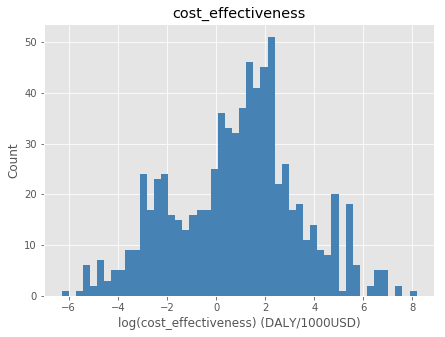

In [12]:
fig, ax = plt.subplots(figsize=(7,5))

plt_df = comb_df[['source', 'cost_effectiveness']].copy()
plt_df['cost_effectiveness'] = np.log(plt_df['cost_effectiveness'])
plt_df.hist(column='cost_effectiveness', bins=50, color='#4682b4', ax=ax)

ax.set_xlabel('log(cost_effectiveness) (DALY/1000USD)')
ax.set_ylabel('Count')

plt.show()

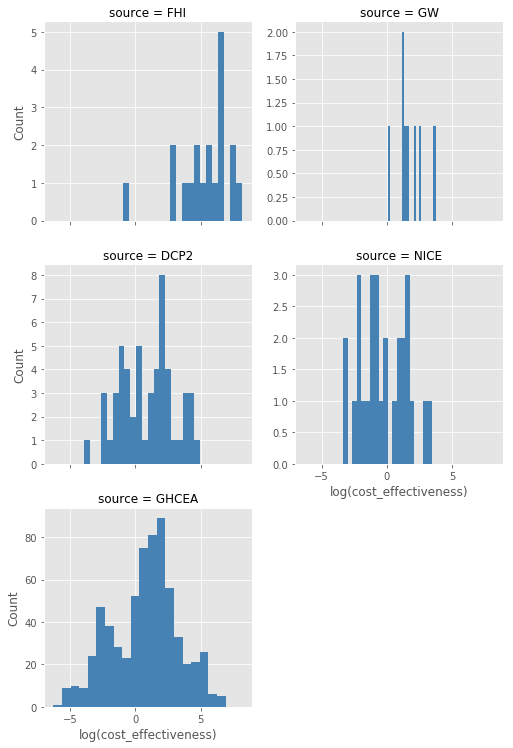

In [13]:
#col="time",  col="year", col_wrap=2, size=4 , sharex=False
g = sns.FacetGrid(plt_df,  col="source", col_wrap=2,  size=3.5, sharey=False)  
g = g.map(plt.hist, "cost_effectiveness", bins=20, color='#4682b4')
g.set_axis_labels("log(cost_effectiveness)", "Count")

In [14]:
# Fit a power law
from scipy.optimize import curve_fit

def pow_func(x, a, b, c):
    return a*(x**b) + c

popt, pcov = curve_fit(pow_func, comb_df['stdev'], comb_df['cost_effectiveness'])
eqn ='Best power fit: y = %5.3f*x^%5.3f + %5.3f' % tuple(popt)
print(eqn)

Best power fit: y = 0.498*x^0.684 + 13.115


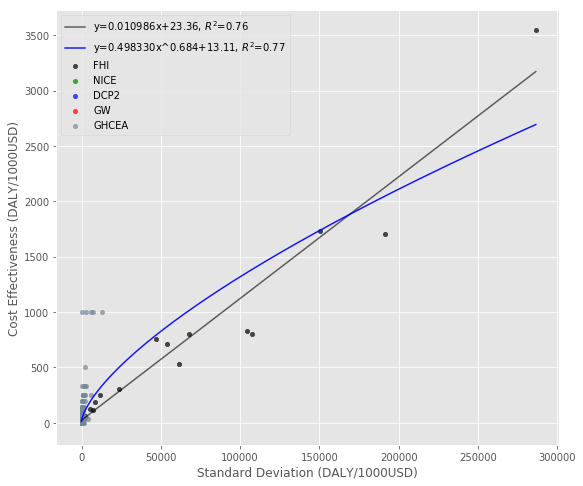

In [15]:
fig, ax = plt.subplots(figsize=(9,8))

group_colors = {'GHCEA': 'lightslategray','GW':'red', 'FHI':'black', 'NICE': 'green', 'DCP2':'blue' }

for src in group_colors.keys():
    x_vals = comb_df[(comb_df['source'] == src)].loc[:,'stdev']
    y_vals = comb_df[(comb_df['source'] == src)].loc[:,'cost_effectiveness']
    ax.scatter(x=x_vals, y=y_vals, color=group_colors[src], s=20, alpha=0.7, label=src) 

ax.set_xlabel('Standard Deviation (DALY/1000USD)')
ax.set_ylabel('Cost Effectiveness (DALY/1000USD)')

x = pd.DataFrame({'stdev': np.linspace(comb_df['stdev'].min(),
    comb_df['stdev'].max(), 5000)})

#Fit linear regression
poly_51 = smf.ols(formula='cost_effectiveness ~ 1 + stdev',
                 data=comb_df, missing='drop').fit()

plt.plot(x, poly_51.predict(x), 'k-', label='y={1:.6f}x+{2:.2f}, $R^2$={0:.2f}' \
    .format(poly_51.rsquared, poly_51.params.stdev,
        poly_51.params.Intercept), alpha=0.6)  

#Fit power law
eqn = 'cost_effectiveness ~ 1 + np.power(stdev, {0})'.format(popt[1])
pow_1 = smf.ols(formula=eqn, data=comb_df, missing='drop').fit()

plt.plot(x, pow_1.predict(x), 'b-', alpha=0.9,
    label='y={1:.6f}x^{3:.3f}+{2:.2f}, $R^2$={0:.2f}' \
    .format(pow_1.rsquared, pow_1.params[1], pow_1.params[0], popt[1]))

#plt.plot(frontier['risks'], frontier['returns'], 'y', label='Efficient Frontier')

plt.legend()
plt.show()

#Remember r^2 isn't really valid for nonlinear curves

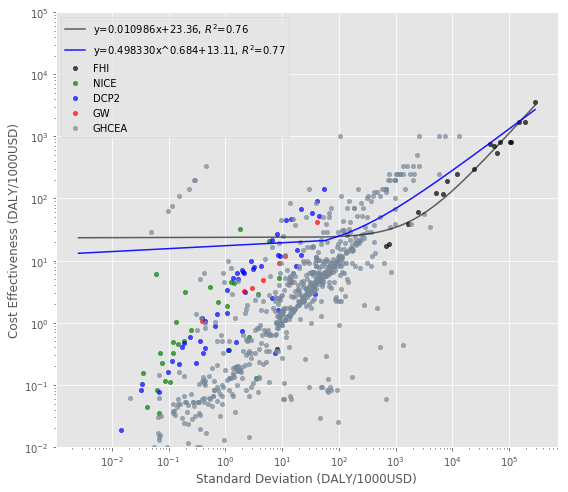

In [16]:
fig, ax = plt.subplots(figsize=(9,8))

for src in group_colors.keys():
    x_vals = comb_df[(comb_df['source'] == src)].loc[:,'stdev']
    y_vals = comb_df[(comb_df['source'] == src)].loc[:,'cost_effectiveness']
    ax.scatter(x=x_vals, y=y_vals, color=group_colors[src], s=20, alpha=0.7, label=src) 

ax.set_xlabel('Standard Deviation (DALY/1000USD)')
ax.set_ylabel('Cost Effectiveness (DALY/1000USD)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-2, 1e5)
#ax.set_xlim(1e-2, 1e6)

plt.plot(x, poly_51.predict(x), 'k-', label='y={1:.6f}x+{2:.2f}, $R^2$={0:.2f}' \
    .format(poly_51.rsquared, poly_51.params.stdev, poly_51.params.Intercept), 
    alpha=0.6) 

plt.plot(x, pow_1.predict(x), 'b-', alpha=0.9, label='y={1:.6f}x^{3:.3f}+{2:.2f}, $R^2$={0:.2f}' \
        .format(pow_1.rsquared, pow_1.params[1], pow_1.params[0], popt[1]))

#plt.plot(frontier['risks'], frontier['returns'], 'y', label='Efficient Frontier') 

plt.legend()
plt.show()

# An Efficient Frontier

Finally, I use a modified version of an algorithm [described on Quantopian](https://blog.quantopian.com/markowitz-portfolio-optimization-2/) to generate a frontier of interventions.  This code uses convex optimization to find the minimum variance portfolio at a variety of cost effectiveness values.  The covariance matrix I use as input is empty except for the diagonal of variances (although this could be changed if you have some reason to think intervention outcomes are correlated in some way).  

Note that the plot below is interactive with scroll-to-zoom enabled.  

In [17]:
#Code for finding the efficient frontier.
def efficient_frontier(covariances, mean_returns):
    '''
    Returns an optimal portfolio, frontier, and portfolio 
    weights given a covariance matrix and matrix of mean returns. 
    Modified from source: 
    https://blog.quantopian.com/markowitz-portfolio-optimization-2/
    '''
    # Turn off progress printing 
    solvers.options['show_progress'] = False
    
    n = len(mean_returns)
    N = 100 
    #Mus are the desired returns
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)] 
    #Sample more at low, high ends for better curve
    mus += [(5000/50)*t for t in range(50)]  
    mus += [(0.01 + (1/100)*t) for t in range(100)]
    mus = sorted(mus)

    S = opt.matrix(covariances)  # convert array to matrix  
    pbar = opt.matrix(mean_returns)  # convert array to matrix

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    #A = opt.matrix(1.0, (1, n))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    frontier_returns = [blas.dot(pbar, x) for x in portfolios] 
    #np.sqrt returns the stdev, not variance
    frontier_risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios] 
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(frontier_returns, frontier_risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x'] 
    
    result = {'optimal_portfolio': np.asarray(wt),'returns': frontier_returns, 
        'risks': frontier_risks, 'portfolios': portfolios}

    return result

In [18]:
#Find the frontier
dim = len(comb_df.index)
covariances = np.zeros((dim, dim), float) #Create covariance matrix
np.fill_diagonal(covariances, comb_df['stdev']**2) #Only diagonal of variances for now
returns = comb_df['cost_effectiveness']
frontier = efficient_frontier(covariances, returns)

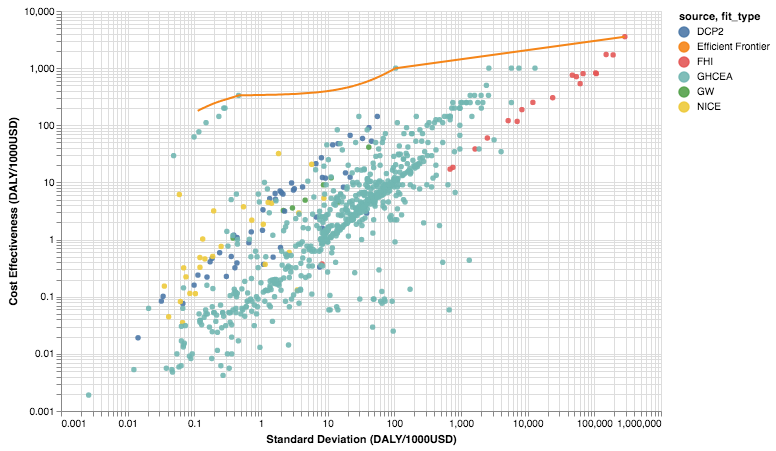

In [25]:
plt_df = comb_df.round({'cost_effectiveness': 4, 'stdev': 4}).copy()

#Create an interactive chart with the frontier
points = alt.Chart(plt_df).mark_circle().encode(
    alt.X('stdev:Q', scale=alt.Scale(type='log'), 
          axis=alt.Axis(title='Standard Deviation (DALY/1000USD)')),
    alt.Y('cost_effectiveness:Q', scale=alt.Scale(type='log'),
          axis=alt.Axis(title='Cost Effectiveness (DALY/1000USD)')),
    color='source', 
    tooltip=['source','intervention','stdev', 'cost_effectiveness'],
    opacity=alt.value(0.9)
).properties(
    width=600,
    height=400
).interactive()

## Just the frontier
lines_df = pd.DataFrame.from_dict({'stdev': frontier['risks'], 
    'yfit': frontier['returns'], 'fit_type': 'Efficient Frontier'})
lines = alt.Chart(lines_df).mark_line().encode(
    x='stdev',
    y='yfit',
    color='fit_type'
)

chart = points + lines
##https://github.com/altair-viz/altair/issues/858, updated altair to solve
#chart.save('meta-returns.html')
chart

# Conclusion

* It seems like there are returns to risk taking for both the individual and combined estimates. This is useful to know because it means a a large error bound on a cost effectiveness estimate shouldn’t be disqualifying on it’s own.
* This framework could be a useful sanity check for future estimates.  For example, if an estimate is far above the existing frontier, it might be worth reviewing it for an incorrect calculation or poor assumption.  But it's important to be careful when doing this because these estimates only cover a small fraction of the possible actions one could take in the world.    
* The intervention with the highest expected impact (and highest uncertainty) is research into diarrheal disease.  This suggests that uncertainty that comes with research is worth it in some cases.  This relationship might be even more clear if we were to add estimates from more esoteric forms of basic scientific research, although some forms of research might not be amenable to this type of analysis.

# References

[1] *Are there returns to risk taking in science, philanthropy, or public policy?* [https://pstblog.com/2017/12/02/risk-return](https://pstblog.com/2017/12/02/risk-return)

[2] *Efficient Frontier.*  Wikipedia. [https://en.wikipedia.org/wiki/Efficient_frontier](https://en.wikipedia.org/wiki/Efficient_frontier)

[3] *psthomas: efficient-frontier*.  GitHub.  [https://github.com/psthomas/efficient-frontier](https://github.com/psthomas/efficient-frontier)

[4] *Global Health Cost Effectiveness Analysis Registry.* Tufts University.  [http://healtheconomics.tuftsmedicalcenter.org/ghcearegistry/](http://healtheconomics.tuftsmedicalcenter.org/ghcearegistry/)

[5] The Cochrane Review Handbook. [http://handbook-5-1.cochrane.org/chapter_7/7_7_3_2_obtaining_standard_deviations_from_standard_errors_and.htm](http://handbook-5-1.cochrane.org/chapter_7/7_7_3_2_obtaining_standard_deviations_from_standard_errors_and.htm)

[6] *Relationship between the range and the standard deviation.* Stack Exchange. 
[https://stats.stackexchange.com/questions/69575/relationship-between-the-range-and-the-standard-deviation](https://stats.stackexchange.com/questions/69575/relationship-between-the-range-and-the-standard-deviation)

[7] *The Efficient Frontier: Markowitz portfolio optimization in Python.* Quantopian.  
[https://blog.quantopian.com/markowitz-portfolio-optimization-2/](https://blog.quantopian.com/markowitz-portfolio-optimization-2/) 